# CPI and BER Data Analysis

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error 
from matplotlib import pyplot as plt
from sklearn.preprocessing import PolynomialFeatures

## Data

In [9]:
CPI = pd.read_csv('./data/CPI.csv')
BER = pd.read_csv('./data/T10YIE.csv')

In [13]:

CPI.shape, BER.shape, CPI.columns, BER.columns

((4087, 2),
 (4215, 2),
 Index(['date', 'CPI'], dtype='object'),
 Index(['date', 'T10YIE'], dtype='object'))

In [21]:
def EDA(df, title="EDA"):
    print(title)
    print("================")
    print("Shape = ", df.shape)
    print("Headers = ", df.columns)
    print("Max. Date = ", df['date'].max())
    print("Min. Date = ", df['date'].min())
    print("Null data = ", dict(df.isna().sum()))

Cleaning

In [22]:
def Cleanup(df):
    df.dropna(inplace=True)
    df.drop_duplicates(inplace = True)
    df["date"] = pd.to_datetime(df["date"])
    return df
BER.rename(columns = {"DATE":"date"}, inplace=True)
CPI = Cleanup(CPI)
BER = Cleanup(BER)


In [23]:
EDA(CPI, "CPI - EDA")

CPI - EDA
Shape =  (4087, 2)
Headers =  Index(['date', 'CPI'], dtype='object')
Max. Date =  2019-10-01 00:00:00
Min. Date =  2008-07-24 00:00:00
Null data =  {'date': 0, 'CPI': 0}


In [24]:
EDA(BER, "BER - EDA")

BER - EDA
Shape =  (4215, 2)
Headers =  Index(['date', 'T10YIE'], dtype='object')
Max. Date =  2019-11-04 00:00:00
Min. Date =  2003-01-02 00:00:00
Null data =  {'date': 0, 'T10YIE': 0}


## Seasonal Average

### CPI

Plot the monthly CPI value as a time series (e.g. take the first CPI  value of each month as that month's CPI). What is the most obvious trend that you can observe in the data?

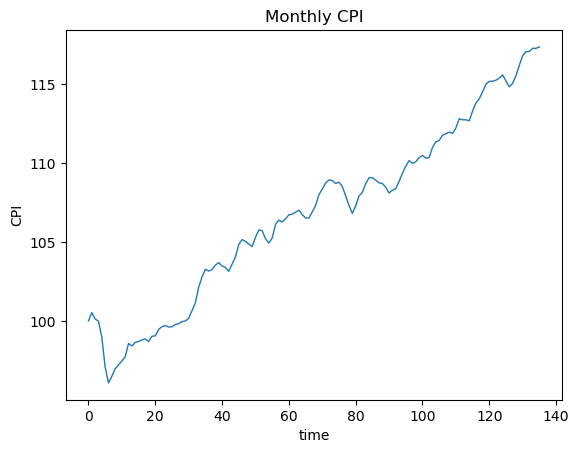

In [66]:
CPI.sort_values(['date'], inplace=True)
CPI1 = CPI.copy()
CPI1['year_mn'] = CPI1['date'].dt.strftime('%Y-%m')
# get the first cpi value for each month in a year
monthly_CPI = CPI1.drop_duplicates('year_mn', keep='first').copy().reset_index().drop(['index'],axis=1) 
monthly_CPI['log_CPI']  = np.log(monthly_CPI['CPI'])

plt.title("Monthly CPI")
plt.plot(monthly_CPI.index,monthly_CPI['CPI'], linewidth=1)
plt.xlabel("time")
plt.ylabel("CPI")
plt.show()


The above map depicts the trend  as a linear trend

## Train Test Split

we split the data into training and testing data sets as outlined in the problem statement

In [78]:
# df_train, df_test = train_test_split(monthly_CPI, test_size=0.2, shuffle=False)
# train, test = train_test_split(monthly_CPI, test_size=0.2, shuffle=False)
is_log = False
train = monthly_CPI[monthly_CPI['year_mn']<'2013-09'].copy()
test =monthly_CPI[monthly_CPI['year_mn']>='2013-09'].copy()

CPI_X = np.array(monthly_CPI.index).reshape(-1, 1)
CPI_y = monthly_CPI.log_CPI if is_log else monthly_CPI.CPI

X_train = np.array(train.index).reshape(-1, 1)
y_train = train.log_CPI if is_log else train.CPI

X_test = np.array(test.index).reshape(-1, 1)
y_test = test.log_CPI if is_log else test.CPI

#### Linear Trend

We will now detrend this data into CPI_t = T_t + R_t. Below, we fit a linear trend to the training data. (You could also experiment with a different way of detrending.)

Coefficients =  [0.16104348]
Intercept =  96.72932632872502


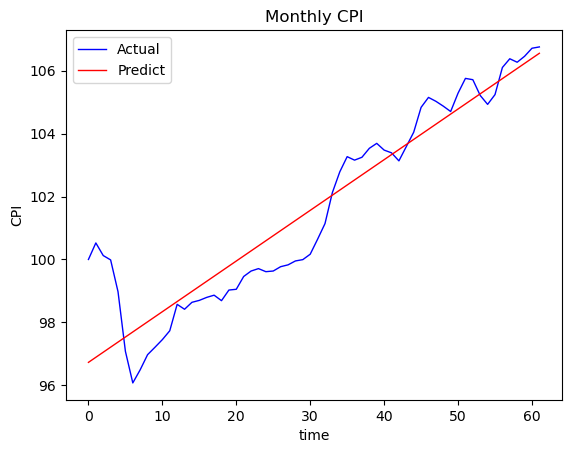

In [79]:
reg = LinearRegression().fit(X_train,y_train)
print("Coefficients = ", reg.coef_)
print("Intercept = ", reg.intercept_)
# expected result b0 = 96.729326328, b1 =  0.161043483

train_pred = reg.predict(X_train)

# plot the comparison between the train actual and predicted values
plt.title("Monthly CPI")
plt.xlabel("time")
plt.ylabel("CPI")
plt.plot(X_train, y_train, color="blue",linewidth=1, label="Actual")
plt.plot(X_train,train_pred, color="red",linewidth=1, label="Predict")
plt.legend()
plt.show()


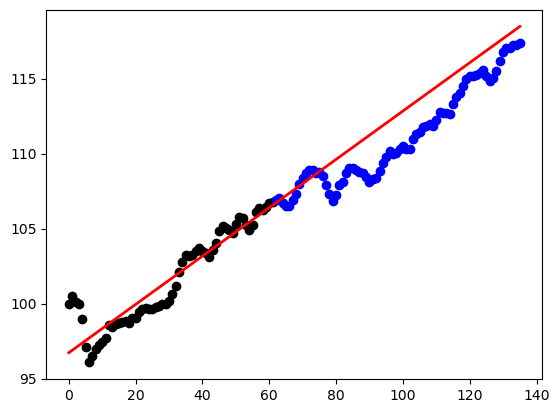

In [94]:
plt.scatter(X_train, y_train, color='black')
plt.scatter(X_test, y_test, color='blue')
plt.plot(CPI_X, reg.predict(CPI_X), color='red', lw=2)
plt.show()

#### Trends and seasonality

Subtract the linear trend from the data to get the residuals R.

Maximum absolute value of the residuals over the training data. =  CPI       3.072387
shift     3.634730
shift2    3.634730
dtype: float64


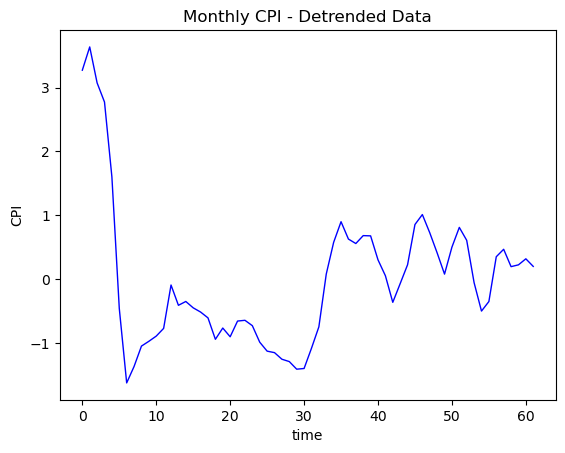

In [105]:
test_pred = reg.predict(X_test)
all_pred = reg.predict(CPI_X)
R_train = y_train-train_pred
R_test = y_test - test_pred
R_all = CPI_y - all_pred

print("Maximum absolute value of the residuals over the training data. = ", R_train.max())
# R_Linear = y_test-test_pred

# plot the comparison between the train actual and predicted values
plt.title("Monthly CPI - Detrended Data")
plt.xlabel("time")
plt.ylabel("CPI")
plt.plot(X_train, R_train, color="blue",linewidth=1)
plt.show()

De-seasonalize the data using AR model

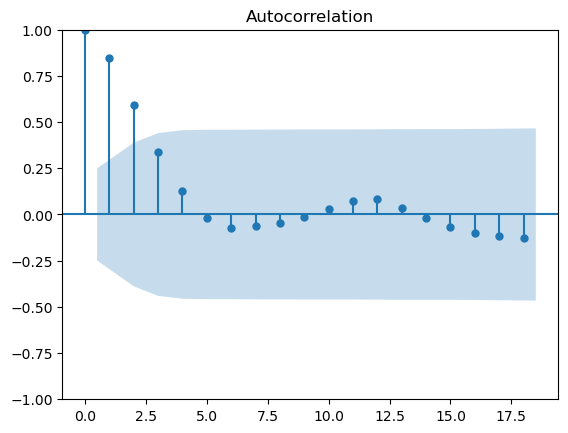

d:\Appdata\Miniconda\envs\mitx\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


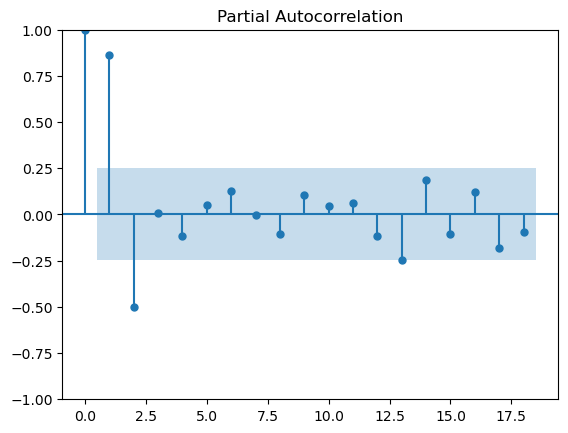

In [106]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
#linear
plot_acf(R_train)
plt.show()
plot_pacf(R_train)
plt.show()

From the partial Autocorrelation, we can see that the highest lag at which the plot extends beyond the statistically significant boundary is at lag 2. This indicates that an AR Model of lag 2 should be sufficient to fit the data. However, we can further verify this by calculating the RMSE of the fit.

In [107]:

R_Linear = R_train.to_frame()
R_Linear['shift'] = R_Linear['CPI'].shift()
R_Linear['shift2'] = R_Linear['shift'].shift()
R_Linear.dropna(inplace=True)

X_t = R_Linear['CPI'].values
X_1 = R_Linear['shift'].values
X_2 = R_Linear['shift2'].values

AIC: 41.979, HQIC: 44.436, BIC: 48.262


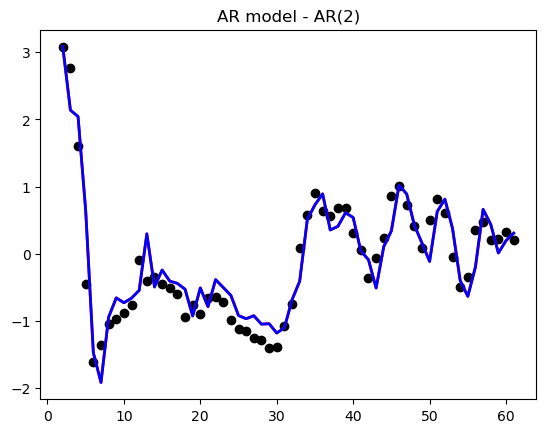

In [119]:
from statsmodels.tsa.ar_model import AutoReg

AR = AutoReg(R_train, lags = 2, trend = 'n').fit()
AR_gen = AutoReg(R_all, lags = 2, trend = 'n')
out = 'AIC: {0:0.3f}, HQIC: {1:0.3f}, BIC: {2:0.3f}'
print(out.format(AR.aic, AR.hqic, AR.bic))
# print(AR.fittedvalues)
plt.title("AR model - AR(2)")
plt.scatter(X_train[2:], X_t, color='black')
plt.plot(X_train[2:], AR.params[0]*X_1 + AR.params[1]*X_2, color='red', lw=2)
plt.plot(X_train[2:], AR.fittedvalues, color='blue', lw=2)
plt.show()

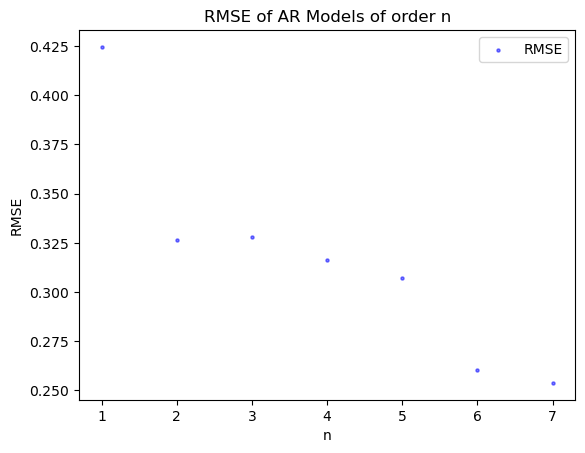

In [118]:
rmse_train=[]

for n in range(1,8):
    model = AutoReg(R_train, lags= n,trend='n')
    model_fit = model.fit()
    predictions=model_fit.predict()
    rmse=(mean_squared_error(R_train[n:], predictions[n:]))**0.5
    rmse_train.append(rmse)

    
    
plt.title("RMSE of AR Models of order n")
plt.scatter(np.arange(1,8),rmse_train,s = 5,color="blue", alpha =0.5, label ="RMSE")
plt.xlabel('n')
plt.ylabel('RMSE')
plt.legend()
plt.show()

Compare AR(n)

In [126]:
#plot RMSE for a range of lags p 
n = 2
rmse_ar=[]
for n in range(1,6):
    model = AutoReg(R_train, lags= n)
    model_fit = model.fit()
    coef = model_fit.params
    past = R_train[len(R_train)-n:].values
    past = [past[i] for i in range(len(past))]    
    test_predictions = list()
    for t in range(len(R_test.dropna())):
        length = len(past)
        lag = [past[i] for i in range(length-n,length)]
        pred = coef[0]
        for d in range(n):
            pred += coef[d+1] * lag[n-d-1]
        obs = R_test.values[t]
        test_predictions.append(pred)
        past.append(obs)
    rmse = (mean_squared_error(R_test.dropna(), test_predictions))**0.5
    rmse_ar.append(rmse)
    print('RMSE for AR(' + str(n) +'):' + str(rmse))





RMSE for AR(1):0.36992170332386093
RMSE for AR(2):0.39104043069964806
RMSE for AR(3):0.3762508376939184
RMSE for AR(4):0.4399093616668139
RMSE for AR(5):0.4321160798236862


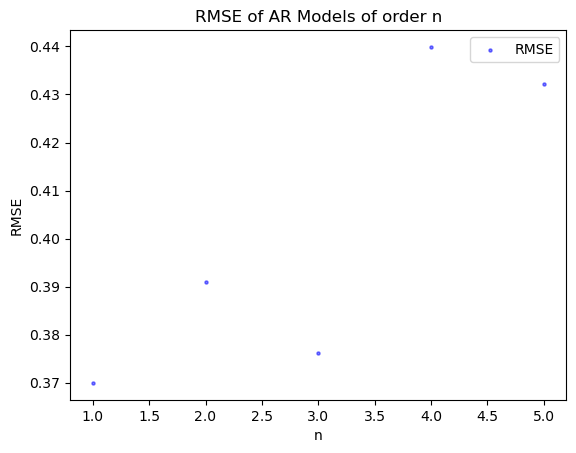

In [129]:
plt.title("RMSE of AR Models of order n")
plt.scatter(np.arange(1,6),rmse_ar,s = 5,color="blue", alpha =0.5, label ="RMSE")
plt.xlabel('n')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [123]:
def rebuild_diffed(series, first_element_original,x,linear_trend):
    if x == 'linear':
        final = series + linear_trend
    else:
        cumsum = pd.Series(series).cumsum()
        final = np.exp(cumsum.fillna(0) + first_element_original)
        if first_element_original == 0:
            final = np.exp(cumsum.fillna(0))
    return final

In [137]:
## Building AR (2) Model 
n = 2
AR2_model = AutoReg(R_train, lags= n).fit()# Here we have used the default value for the trend parameter
coef = AR2_model.params
print(coef)
print(X_train[0],X_train[-1])
# walk forward over time steps in test
past = R_train[len(R_train)-n:].values
past = [past[i] for i in range(len(past))]
test_predictions = list()
training_predictions = AR2_model.predict(start = X_train[0][0], end =X_train[-1][0])
for t in range(len(R_test)):
    length = len(past)
    lag = [past[i] for i in range(length-n,length)]
    pred = coef[0]
    for d in range(n):
        pred += coef[d+1] * lag[n-d-1]
    obs = R_test.values[t]
    test_predictions.append(pred)
    past.append(obs)
final_training = (rebuild_diffed(training_predictions,np.log(y_train)[0],"linear",train_pred))
final_test = (rebuild_diffed(test_predictions,np.log(y_test.iloc[-1]),"linear",test_pred))

const    -0.043105
CPI.L1    1.323666
CPI.L2   -0.530797
dtype: float64
[0] [61]


We now plot the final model predictions and the actual observed data together to visualize the fit.

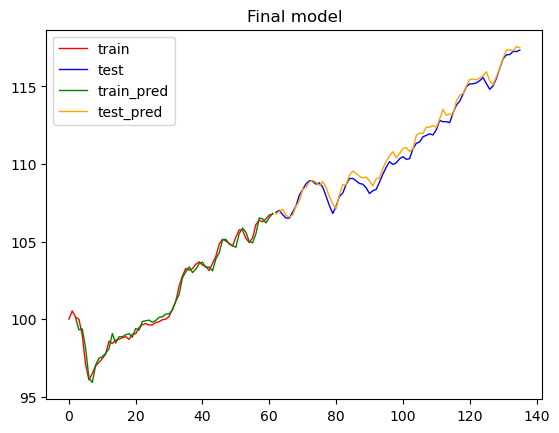

In [138]:
plt.title("Final model")
plt.plot(X_train,y_train, color="red", label="train", linewidth=1)
plt.plot(X_test,y_test, color="blue", label="test", linewidth=1)
plt.plot(X_train,final_training, color="green", label="train_pred", linewidth=1)
plt.plot(X_test,final_test, color="orange", label="test_pred", linewidth=1)
plt.legend()
plt.show()

d:\Appdata\Miniconda\envs\mitx\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


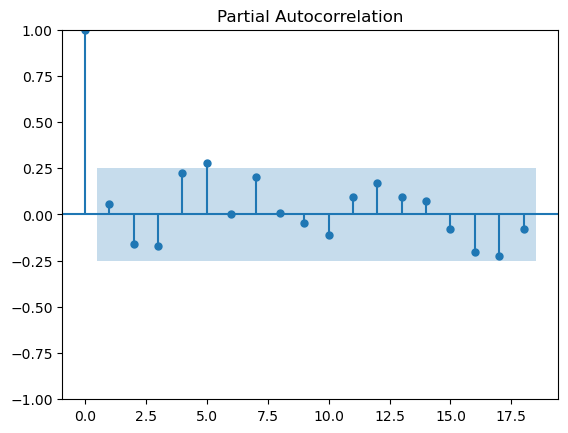

In [139]:
residuals = (R_train - training_predictions)[2:]
plot_pacf(residuals)
plt.show()

In [146]:
print(y_test.shape, final_test.shape)
rmse = mean_squared_error(y_test,final_test, squared=False)
print("The rmse of the final fit is " + str(rmse))

(74,) (74,)
The rmse of the final fit is 0.3910404306996479


## Inflation Rate (BRE)

Inflation Rate In the next part of the question, since we will be working with external regressors that have different units(such as BER), we must first convert all the data into an equivalent form, i.e monthly inflation rates. We will first do so for CPI from which inflation rates can be simply calculated as

IR_t = (CPI_t -CPI_t-1)/CPI_t-1

In [147]:
def calc_inflation_rate(data):
    ir = []
    for i in range(1,len(data)):
        ir_temp = (data[i]-data[i-1])/data[i-1] *100 # in percentage     
        ir.append(ir_temp)
#         print(i)
    return ir

In [149]:
#calculate monthly inflation from CPI
val = calc_inflation_rate(monthly_CPI.CPI.values)
val2=np.log(monthly_CPI.CPI).diff().values*100  # in percentage

monthly_CPI.loc[1:, 'IR_cpi'] = val
monthly_CPI['diff_log'] = val2

cpi_ir_train = (monthly_CPI[monthly_CPI.year_mn<'2013-09'].copy())
cpi_ir_test = (monthly_CPI[monthly_CPI.year_mn >='2013-09'].copy())

print("The inflation rate from CPI for the month of February in 2013 was %0.9f" % monthly_CPI[monthly_CPI.year_mn =='2013-02']['IR_cpi'] + " %")
print("The inflation rate from CPI for the month of February in 2013 was %0.9f" % monthly_CPI[monthly_CPI.year_mn =='2013-02']['diff_log'] + " %")

The inflation rate from CPI for the month of February in 2013 was 0.295722930 %
The inflation rate from CPI for the month of February in 2013 was 0.295286530 %


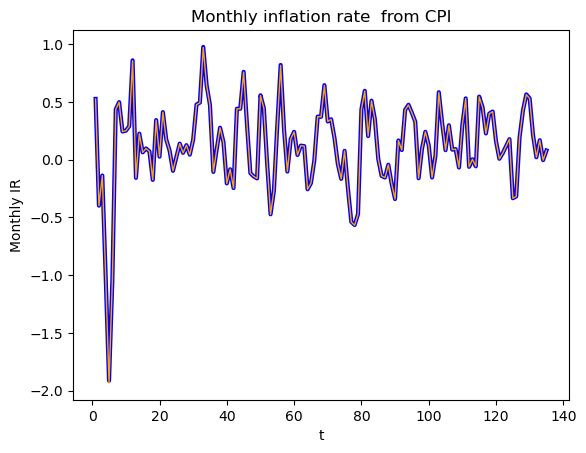

In [157]:
plt.title("Monthly inflation rate  from CPI")
plt.plot(monthly_CPI.index,monthly_CPI['IR_cpi'], color="blue", linewidth=3)
plt.plot(monthly_CPI.index,monthly_CPI['diff_log'], color="orange", linewidth=1)
plt.xlabel('t')
plt.ylabel('Monthly IR')
plt.show()

In [154]:

BER['date'] =pd.to_datetime(BER['date'])
BER['YearMonth'] = BER['date'].dt.strftime('%Y-%m')
BER = BER.drop(BER[BER.YearMonth< '2008-07'].index)
BER = BER.dropna()
# print(ber)

ber_monthly = pd.DataFrame(columns =['YearMonth','BER'])
ber_monthly['BER'] =BER.groupby('YearMonth').T10YIE.mean().values
ber_monthly['YearMonth'] = monthly_CPI.year_mn



ber_ir_train = (ber_monthly[ber_monthly.YearMonth<'2013-09'].copy())
ber_ir_test = (ber_monthly[ber_monthly.YearMonth >='2013-09'].copy())

# print(ber_monthly.BER-ber_ir_train.BER)
ber_ir_train['IR_ber'] = ((ber_ir_train.BER.values/100+1)**(1/12)-1)*100
ber_ir_test['IR_ber'] = ((ber_ir_test.BER.values/100+1)**(1/12)-1)*100
print("The inflation rate from BER for the month of February in 2013 was %0.9f" % ber_ir_train[ber_ir_train.YearMonth == '2013-02']['IR_ber'] + " %")


The inflation rate from BER for the month of February in 2013 was 0.210441852 %


We can now overlay these estimates and plot them together

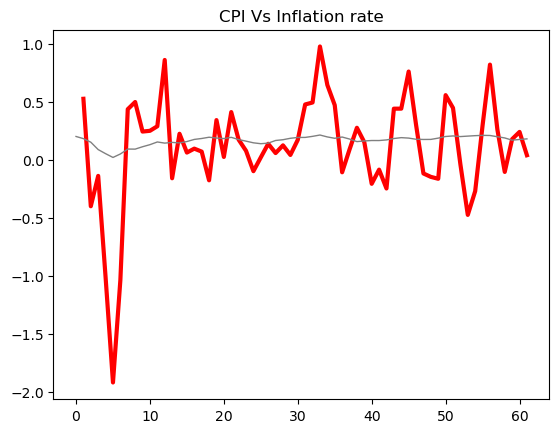

In [172]:
plt.title("CPI Vs Inflation rate")
plt.plot(X_train[0:],cpi_ir_train.IR_cpi, color="red", linewidth=3)
plt.plot(ber_ir_train.index[0:],ber_ir_train.IR_ber, color="gray", linewidth=1)

we incorporate BER data as external regressors , i.e. exogenous variables to help better our predictions. In order to identify the lag between the external regressor and the CPI timeseries, we plot the cross correlation plots between BER and CPI.

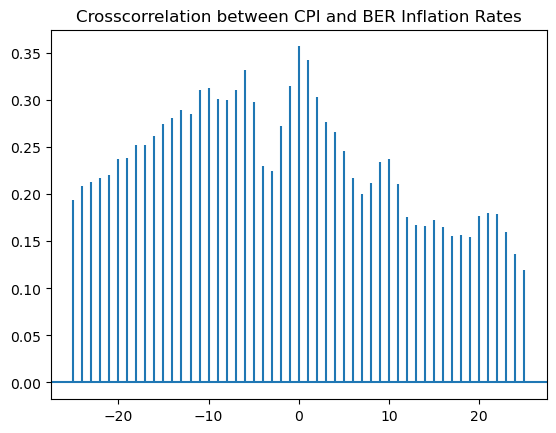

In [161]:
from statsmodels.tsa.stattools import ccf
plt.xcorr(ber_ir_train.IR_ber[1:],cpi_ir_train.IR_cpi[1:], maxlags = 25)
plt.title('Crosscorrelation between CPI and BER Inflation Rates')
plt.show()

We see that for BER and CPI, the CCF plot is not as clear but we see that the peak correlation occurs at a lag of 0 and another peak at a lag of (-6). While multiple lag terms can be incorporated, we begin by including the BER at the same time instant as a regressor.

In [163]:

import statsmodels.api as sm
exogenous = ber_ir_train.copy().drop(['BER'],axis=1)
exogenous =exogenous.drop(['YearMonth'],axis=1).drop([0,1]).values # exogenous start at index 2, i.e. 2008-09

endogenous = cpi_ir_train.IR_cpi.iloc[2:].reset_index().drop(['index'],axis =1)# drop first 2 rows to match with start of exogenous
model_external = sm.tsa.statespace.SARIMAX(endogenous, exogenous, order=(2,0,0), coerce_errors =True).fit(disp=False) #AR(2)
coef = model_external.params
#print(model_external.summary())

training_predictions3 = model_external.predict(start =2, end = len(endogenous.index) - 1, exog = exogenous)# training prediction start 2008-11

In [164]:
k= 2
coef = model_external.params
past = endogenous.IR_cpi[len(endogenous.IR_cpi)-k:].values #exact the last k items in training data
past = [past[i] for i in range(k)]
test_predictions3 = list()

#prediction of the first time step
#past_ps = ps_ir_train.IR_ps.values[-1] # since lag was 1 between ir_cpi and ir_ps
pred = coef['ar.L2']*past[0] + coef['ar.L1']*past[1] + coef['x1'] * ber_ir_test.IR_ber.iloc[0] 
test_predictions3.append(pred)
obs = cpi_ir_test.IR_cpi.values[0]
past.append(obs)

for t in range(1,len(cpi_ir_test.IR_cpi)):
    length = len(past)
    lag = [past[i] for i in range(length-2,length)]
    pred = coef['ar.L2']*lag[0] + coef['ar.L1']*lag[1] +  coef['x1'] * ber_ir_test.IR_ber.iloc[t] 
    test_predictions3.append(pred)
    obs = cpi_ir_test.IR_cpi.values[t]
    past.append(obs)
print("The rmse of this final fit is " + str(mean_squared_error(cpi_ir_test.IR_cpi.values[:-2], test_predictions3[:-2])**0.5))
print("The mape of this final fit is " + str(mean_absolute_percentage_error(cpi_ir_test.IR_cpi.values[:-2],test_predictions3[:-2])))

The rmse of this final fit is 0.23710432940178633
The mape of this final fit is 2.2383360909065595


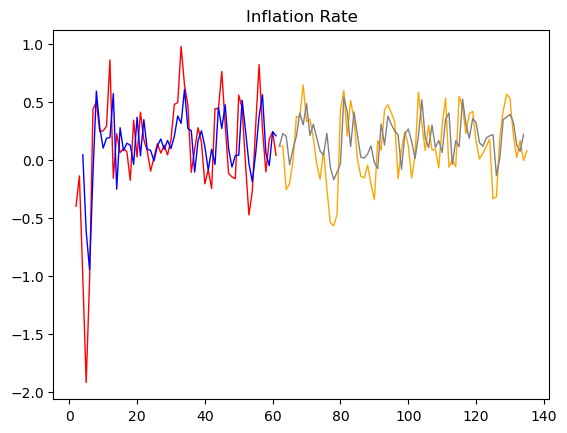

In [165]:
plt.title("Inflation Rate")
plt.plot(endogenous.index+2,endogenous.IR_cpi, color="red", linewidth=1)
plt.plot(training_predictions3.index+2,training_predictions3, color="blue", linewidth=1)
plt.plot(cpi_ir_test.index,cpi_ir_test.IR_cpi, color="orange", linewidth=1)
plt.plot(cpi_ir_test.index[:-1],test_predictions3[:-1], color="gray", linewidth=1)
plt.show()

We see that the model predictions are very good, and match the original values

Lastly, we try to better the model predictions. One way to do this would be to incorporate Moving Average terms into the model. We start by including an MA(1) term to get an ARMA(1,1) model. We then make predictions as shown above.

In [166]:
exogenous = ber_ir_train.copy().drop(['BER'],axis=1)
exogenous =exogenous.drop(['YearMonth'],axis=1).drop([0,1]).values # exogenous start at index 2, i.e. 2008-09

endogenous = cpi_ir_train.IR_cpi.iloc[2:].reset_index().drop(['index'],axis =1)# drop first 2 rows to match with start of exogenous
model_external = sm.tsa.statespace.SARIMAX(endogenous, exogenous, order=(2,0,1), coerce_errors =True).fit(disp=False) #AR(2)
coef = model_external.params
print(model_external.summary())
training_predictions4 = model_external.predict(start =2, end = len(endogenous.index) - 1, exog = exogenous)# training prediction start 2008-11

                               SARIMAX Results                                
Dep. Variable:                 IR_cpi   No. Observations:                   60
Model:               SARIMAX(2, 0, 1)   Log Likelihood                 -24.044
Date:                Wed, 19 Apr 2023   AIC                             58.088
Time:                        00:58:47   BIC                             68.560
Sample:                             0   HQIC                            62.184
                                 - 60                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.8719      0.537      1.625      0.104      -0.180       1.923
ar.L1          0.7339      0.802      0.916      0.360      -0.837       2.305
ar.L2         -0.3016      0.426     -0.707      0.4

In [167]:
k= 2
coef = model_external.params
past = endogenous.IR_cpi[len(endogenous.IR_cpi)-k:].values
past = [past[i] for i in range(k)]
test_predictions4 = list()

#prediction of the first time step
pred = coef['ar.L2']*past[0] + coef['ar.L1']*past[1] +  coef['ma.L1'] * past[1] + coef['x1'] * ber_ir_test.IR_ber.iloc[0] 
test_predictions4.append(pred)
obs = cpi_ir_test.IR_cpi.values[0]
past.append(obs)

for t in range(1,len(cpi_ir_test.IR_cpi)):
    length = len(past)
    lag = [past[i] for i in range(length-2,length)]
    pred = coef['ar.L2']*lag[0] + coef['ar.L1']*lag[1] +  coef['ma.L1'] * lag[1]+coef['x1'] * ber_ir_test.IR_ber.iloc[t] 
    test_predictions4.append(pred)
    obs = cpi_ir_test.IR_cpi.values[t]
    past.append(obs)
print("The rmse of this final fit is " + str(mean_squared_error(cpi_ir_test.IR_cpi.values[:-2], test_predictions4[:-2])**0.5))
print("The mape of this final fit is " + str(mean_absolute_percentage_error(cpi_ir_test.IR_cpi.values[:-2], test_predictions4[:-2])))

The rmse of this final fit is 0.2360974309068598
The mape of this final fit is 2.258112265517611


We see that even though the RSME has increased, the percentage error MAPE has halved. The decrease of MAPE  means that

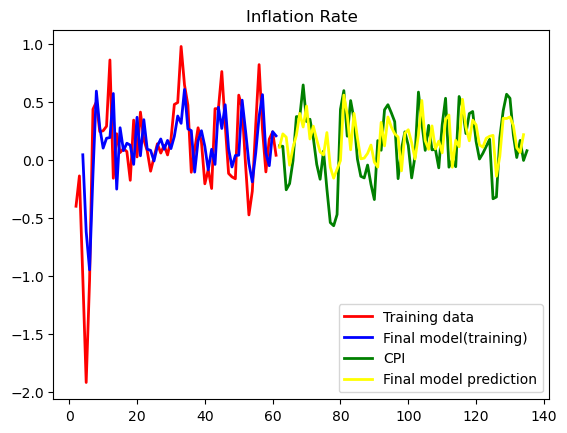

In [171]:
plt.title("Inflation Rate")
plt.plot(endogenous.index+2,endogenous.IR_cpi, color="red", linewidth=2, label="Training data")
plt.plot(training_predictions3.index+2,training_predictions3, color="blue", linewidth=2, label="Final model(training)")
plt.plot(cpi_ir_test.index,cpi_ir_test.IR_cpi, color="green", linewidth=2,label="CPI")
plt.plot(cpi_ir_test.index[:-1],test_predictions4[:-1], color="yellow", linewidth=2,label="Final model prediction")
plt.legend()
plt.show()